# World Cup Prediction 
## Introduction
  This project aim to use past data of international football match to predict the outcome of matches and simulate the 2018 world cup to find the champion.

  The data that I use in this project is from Kaggle:
1. [FIFA Ranking](https://www.kaggle.com/tadhgfitzgerald/fifa-international-soccer-mens-ranking-1993now) 
2. [International Footbal Match Result from 1872 to 2018](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017) 
3. [2018 FIFA World Cup Group Stage Schedule](https://www.kaggle.com/ahmedelnaggar/fifa-worldcup-2018-dataset) 

There are 2 problem that I will try to solve 
1. predict the outcome of the match (classification problem)
2. predict the score difference of the match (regression problem) 


### Mount and import data from google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Data path 
ranking_path = '/content/drive/My Drive/Pattern Recognition/data/fifa_ranking.csv'
matches_path = '/content/drive/My Drive/Pattern Recognition/data/results.csv'
schedule_path = '/content/drive/My Drive/Pattern Recognition/data/World Cup 2018 Dataset.csv'

In [0]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
# import 
rankings = pd.read_csv(ranking_path)
matches = pd.read_csv(matches_path)
schedule = pd.read_csv(schedule_path) 

### Prepare data

Let's explore the data first. We will focus on the rankings and matches data set because that is the input of our model


In [5]:
rankings.head(3)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08


In [6]:
matches.head(3)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False


In [7]:
schedule.head(3)

,Team,Group,Previous \nappearances,Previous \ntitles,Previous\n finals,Previous\n semifinals,Current \nFIFA rank,First match \nagainst,Match index,history with \nfirst opponent\n W-L,history with\n first opponent\n goals,Second match\n against,Match index.1,history with\n second opponent\n W-L,history with\n second opponent\n goals,Third match\n against,Match index.2,history with\n third opponent\n W-L,history with\n third opponent\n goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN


In [0]:
# QoL functions

def get_rank(rank):
  r = rank
  r = rank.replace({'IR Iran' : 'Iran'})
  r['rank_date'] = pd.to_datetime(r['rank_date'])
  
  ## selected column
  col = ['rank','country_full','rank_date', 'total_points', 'country_abrv']
  ##
  return r[col]

def get_matches(matches):
  m = matches
  m = m.replace({'Germany DR': 'Germany', 'China': 'China PR'})
  m['date'] = pd.to_datetime(m['date'])
  return m

In [0]:
# matches (zero NaN)
match = get_matches(matches)

# ranking (zero NaN)
rank = get_rank(rankings)

# schedule (last row == NaN)
schedule = schedule[['Team','Group','First match \nagainst', 'Second match\n against', 'Third match\n against']].dropna()
schedule = schedule.replace({"IRAN": "Iran", "Costarica": "Costa Rica", "Porugal": "Portugal", "Columbia": "Colombia", "Korea" : "Korea Republic"})
schedule.set_index('Team',  inplace=True)

### Feature extraction


In [0]:
rank = rank.set_index('rank_date').groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [11]:
match = match.merge(rank, left_on=['date','home_team'], right_on=['rank_date', 'country_full'])
match = match.merge(rank, left_on=['date','away_team'], right_on=['rank_date', 'country_full'], suffixes=['_home','_away'])
match.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,rank_home,country_full_home,total_points_home,country_abrv_home,rank_date_away,rank_away,country_full_away,total_points_away,country_abrv_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,59.0,Bolivia,0.0,BOL,1993-08-08,22.0,Uruguay,0.0,URU
1,1993-08-08,Brazil,Mexico,1,1,Friendly,Maceió,Brazil,False,1993-08-08,8.0,Brazil,0.0,BRA,1993-08-08,14.0,Mexico,0.0,MEX
2,1993-08-08,Ecuador,Venezuela,5,0,FIFA World Cup qualification,Quito,Ecuador,False,1993-08-08,35.0,Ecuador,0.0,ECU,1993-08-08,94.0,Venezuela,0.0,VEN
3,1993-08-08,Guinea,Sierra Leone,1,0,Friendly,Conakry,Guinea,False,1993-08-08,65.0,Guinea,0.0,GUI,1993-08-08,86.0,Sierra Leone,0.0,SLE
4,1993-08-08,Paraguay,Argentina,1,3,FIFA World Cup qualification,Asunción,Paraguay,False,1993-08-08,67.0,Paraguay,0.0,PAR,1993-08-08,5.0,Argentina,0.0,ARG


In [12]:
match["tournament"].value_counts()[:10]

Friendly                                6717
FIFA World Cup qualification            4116
UEFA Euro qualification                 1406
African Cup of Nations qualification     897
AFC Asian Cup qualification              426
FIFA World Cup                           313
CECAFA Cup                               308
African Cup of Nations                   304
COSAFA Cup                               229
Copa América                             225
Name: tournament, dtype: int64

In [0]:
data = match[['home_team','away_team','home_score','away_score','tournament','rank_home','rank_away','country','total_points_home','total_points_away','rank_date_home']]

In [14]:
# create new features: rank difference, is home, is friendly
data['rank_diff'] = data['rank_home'] - data['rank_away']
data['is_home'] = data['home_team'] == data['country']
data['is_friendly'] = data['tournament'] == 'Friendly'
data['points_diff'] = data.loc[:,'total_points_home'] - data.loc[:,'total_points_away']

# create target: outcome, score difference
##
def class_outcome(x):
  if x > 0: return 1    # win
  else: return 0 # draw/loss
  # else: return 2        # lose
##
data['score_diff'] = data.loc[:,'home_score'] - data.loc[:,'away_score']
data['outcome'] = data.loc[:,'score_diff'].apply(class_outcome)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

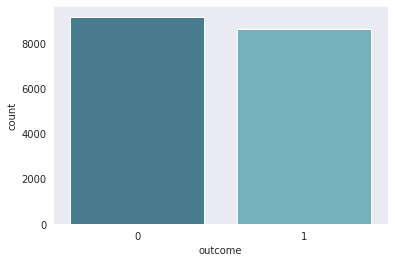

In [15]:
sns.set_style('dark')
sns.countplot('outcome',data=data, palette='GnBu_d')
plt.show()
# 1 == win 
# 0 == lose

win     8589
lose    4873
draw    4277
Name: score_diff, dtype: int64


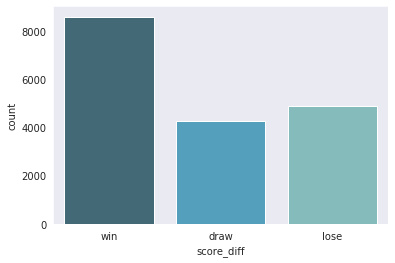

In [16]:
# alt outcome
def outcome3(x):
  if x > 0: return 'win'    # win
  elif x == 0: return 'draw' # draw
  else: return 'lose'        # lose
stats = data['score_diff'].apply(outcome3)
print(stats.value_counts())
# plot 
sns.countplot(stats, palette='GnBu_d')
plt.show()

Text(0.5, 1.0, 'rank difference')

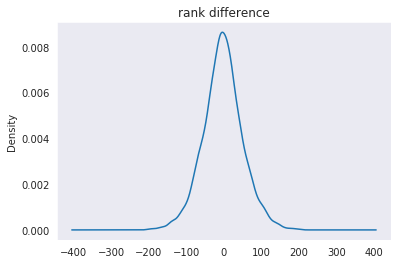

In [17]:
plt.figure()
data['rank_diff'].plot.kde()
plt.title('rank difference')

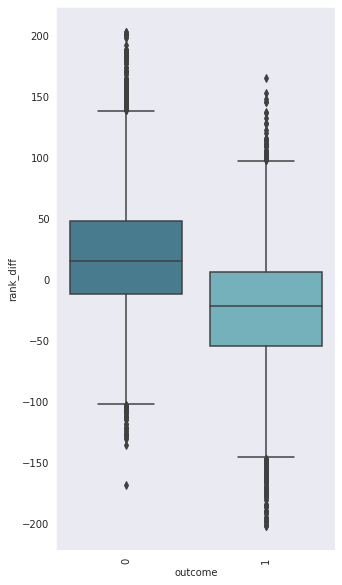

'\n  assumption : match with high ranl gap tend to be in favor of team with higher rank\n  real : the assumption is true but not always\n'

In [18]:
plt.figure(figsize=(5,10))
var = 'rank_diff'
sns.boxplot(x = 'outcome', y=var, data=data,palette='GnBu_d')
plt.xticks(rotation=90)
plt.show()

"""
  assumption : match with high ranl gap tend to be in favor of team with higher rank
  real : the assumption is true but not always
"""

In [19]:
data.loc[:,'avg_rank'] = (data.loc[:,'rank_home'] + data.loc[:,'rank_away'])/2

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
data.describe()

,home_score,away_score,rank_home,rank_away,total_points_home,total_points_away,rank_diff,points_diff,score_diff,outcome,avg_rank
count,17739.000000,17739.000000,17739.000000,17739.000000,17739.000000,17739.000000,17739.000000,17739.000000,17739.000000,17739.000000,17739.000000
mean,1.609053,1.065562,76.042054,78.430464,154.728131,149.151144,-2.388410,5.576986,0.543492,0.484187,77.236259
std,1.625874,1.249078,51.016675,52.050922,303.042522,293.976589,52.885738,190.227669,2.207231,0.499764,44.235444
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-202.000000,-1545.430000,-17.000000,0.000000,1.500000
25%,0.000000,0.000000,33.000000,35.000000,0.000000,0.000000,-35.000000,0.000000,-1.000000,0.000000,41.500000
50%,1.000000,1.000000,70.000000,71.000000,0.000000,0.000000,-3.000000,0.000000,0.000000,0.000000,72.500000
75%,2.000000,2.000000,112.000000,115.000000,187.480000,171.605000,29.000000,0.000000,2.000000,1.000000,107.000000
max,31.000000,17.000000,209.000000,209.000000,1770.060000,1770.060000,203.000000,1596.130000,31.000000,1.000000,204.000000


## Feature Selection

This is what I have try so far

### basic feature 

In [21]:
data.head()


,home_team,away_team,home_score,away_score,tournament,rank_home,rank_away,country,total_points_home,total_points_away,rank_date_home,rank_diff,is_home,is_friendly,points_diff,score_diff,outcome,avg_rank
0,Bolivia,Uruguay,3,1,FIFA World Cup qualification,59.0,22.0,Bolivia,0.0,0.0,1993-08-08,37.0,True,False,0.0,2,1,40.5
1,Brazil,Mexico,1,1,Friendly,8.0,14.0,Brazil,0.0,0.0,1993-08-08,-6.0,True,True,0.0,0,0,11.0
2,Ecuador,Venezuela,5,0,FIFA World Cup qualification,35.0,94.0,Ecuador,0.0,0.0,1993-08-08,-59.0,True,False,0.0,5,1,64.5
3,Guinea,Sierra Leone,1,0,Friendly,65.0,86.0,Guinea,0.0,0.0,1993-08-08,-21.0,True,True,0.0,1,1,75.5
4,Paraguay,Argentina,1,3,FIFA World Cup qualification,67.0,5.0,Paraguay,0.0,0.0,1993-08-08,62.0,True,False,0.0,-2,0,36.0


In [0]:
"""
try :
  rank diff
  point_diff
  is_home
  is_friendly
    don't use friendly match
  swap home away // shouldn't effect
  

rankdiff, pointdiff, is friendly, ishome, avgrank?, 

"""
# import libs
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score

# fixed seed 
seed = 1

In [0]:
# basic 
features = ['avg_rank','rank_diff','is_home']

# features = ['rank_home','rank_away','rank_diff','is_home','is_friendly']
X_clf_train, X_clf_test, y_clf_train, y_clf_test =  train_test_split(data[features], data[['outcome']], test_size=0.2, random_state=seed)
X_clf_train, X_clf_val, y_clf_train, y_clf_val =  train_test_split(X_clf_train, y_clf_train, test_size=0.2, random_state=seed)

In [24]:
dTree = DecisionTreeClassifier(random_state=seed, max_depth=6)
dTree.fit(X_clf_train,y_clf_train)

# train data set 
dTree_train_pred = dTree.predict(X_clf_train)
print('============ Train data ==============')
print(classification_report(y_clf_train,dTree_train_pred))

# val data set 
dTree_val_pred = dTree.predict(X_clf_val)
print('============ Validation data ==============')
print(classification_report(y_clf_val,dTree_val_pred))

# test set
print('============ test data ==============')
dTree_test_pred = dTree.predict(X_clf_test)
print(classification_report(y_clf_test,dTree_test_pred))

print(roc_auc_score(y_clf_test,dTree.predict_proba(X_clf_test)[:,1]))

============ Train data ==============
              precision    recall  f1-score   support

           0       0.70      0.69      0.70      5903
           1       0.67      0.69      0.68      5449

    accuracy                           0.69     11352
   macro avg       0.69      0.69      0.69     11352
weighted avg       0.69      0.69      0.69     11352

============ Validation data ==============
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      1453
           1       0.67      0.67      0.67      1386

    accuracy                           0.68      2839
   macro avg       0.68      0.68      0.68      2839
weighted avg       0.68      0.68      0.68      2839

============ test data ==============
              precision    recall  f1-score   support

           0       0.68      0.69      0.68      1794
           1       0.68      0.66      0.67      1754

    accuracy                           0.68      3548
   macr

In [25]:
dTree.predict_proba(X_clf_test)

array([[0.85      , 0.15      ],
       [0.7122807 , 0.2877193 ],
       [0.13868613, 0.86131387],
       ...,
       [0.41440378, 0.58559622],
       [0.32142857, 0.67857143],
       [0.60074627, 0.39925373]])

In [26]:
svc = SVC(C=0.5, random_state=seed)
svc.fit(X_clf_train,y_clf_train)

# train data set 
svc_train_pred = svc.predict(X_clf_train)
print('============ Train data ==============')
print(classification_report(y_clf_train,svc_train_pred))

# val data set 
svc_val_pred = svc.predict(X_clf_val)
print('============ Validation data ==============')
print(classification_report(y_clf_val,svc_val_pred))

# test set
print('============ test data ==============')
svc_test_pred = svc.predict(X_clf_test)
print(classification_report(y_clf_test,svc_test_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


============ Train data ==============
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      5903
           1       0.68      0.63      0.65      5449

    accuracy                           0.68     11352
   macro avg       0.68      0.68      0.68     11352
weighted avg       0.68      0.68      0.68     11352

============ Validation data ==============
              precision    recall  f1-score   support

           0       0.67      0.72      0.69      1453
           1       0.68      0.63      0.65      1386

    accuracy                           0.67      2839
   macro avg       0.67      0.67      0.67      2839
weighted avg       0.67      0.67      0.67      2839

============ test data ==============
              precision    recall  f1-score   support

           0       0.67      0.74      0.70      1794
           1       0.70      0.63      0.66      1754

    accuracy                           0.68      3548
   macr

### add is friendly


result : no significant change


In [0]:
# add is friendly
features = ['avg_rank','rank_diff','is_home','is_friendly']
X_clf_train, X_clf_test, y_clf_train, y_clf_test =  train_test_split(data[features], data[['outcome']], test_size=0.2, random_state=seed)
X_clf_train, X_clf_val, y_clf_train, y_clf_val =  train_test_split(X_clf_train, y_clf_train, test_size=0.2, random_state=seed)

In [28]:
dTree2 = DecisionTreeClassifier(random_state=seed, max_depth=6)
dTree2.fit(X_clf_train,y_clf_train)

# train data set 
dTree2_train_pred = dTree2.predict(X_clf_train)
print('============ Train data ==============')
print(classification_report(y_clf_train,dTree2_train_pred))

# val data set 
dTree2_val_pred = dTree2.predict(X_clf_val)
print('============ Validation data ==============')
print(classification_report(y_clf_val,dTree2_val_pred))

# test set
print('============ test data ==============')
dTree2_test_pred = dTree2.predict(X_clf_test)
print(classification_report(y_clf_test,dTree2_test_pred))

print(roc_auc_score(y_clf_test,dTree2.predict_proba(X_clf_test)[:,1]))

============ Train data ==============
              precision    recall  f1-score   support

           0       0.70      0.69      0.70      5903
           1       0.67      0.69      0.68      5449

    accuracy                           0.69     11352
   macro avg       0.69      0.69      0.69     11352
weighted avg       0.69      0.69      0.69     11352

============ Validation data ==============
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      1453
           1       0.67      0.67      0.67      1386

    accuracy                           0.68      2839
   macro avg       0.68      0.68      0.68      2839
weighted avg       0.68      0.68      0.68      2839

============ test data ==============
              precision    recall  f1-score   support

           0       0.68      0.69      0.68      1794
           1       0.68      0.66      0.67      1754

    accuracy                           0.68      3548
   macr

### drop friendly match from data


result : significant improve


In [29]:
df = data[data['is_friendly']!=True]
df.info()
# data decreased for about 6k entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11022 entries, 0 to 17738
Data columns (total 18 columns):
home_team            11022 non-null object
away_team            11022 non-null object
home_score           11022 non-null int64
away_score           11022 non-null int64
tournament           11022 non-null object
rank_home            11022 non-null float64
rank_away            11022 non-null float64
country              11022 non-null object
total_points_home    11022 non-null float64
total_points_away    11022 non-null float64
rank_date_home       11022 non-null datetime64[ns]
rank_diff            11022 non-null float64
is_home              11022 non-null bool
is_friendly          11022 non-null bool
points_diff          11022 non-null float64
score_diff           11022 non-null int64
outcome              11022 non-null int64
avg_rank             11022 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(7), int64(4), object(4)
memory usage: 1.5+ MB


In [0]:
# drop friendly match
features = ['avg_rank','rank_diff','is_home']

X_clf_train, X_clf_test, y_clf_train, y_clf_test =  train_test_split(df[features], df[['outcome']], test_size=0.2, random_state=seed)
X_clf_train, X_clf_val, y_clf_train, y_clf_val =  train_test_split(X_clf_train, y_clf_train, test_size=0.2, random_state=seed)

In [31]:
dTree3 = DecisionTreeClassifier(random_state=seed, max_depth=5)
dTree3.fit(X_clf_train,y_clf_train)

# train data set 
dTree3_train_pred = dTree3.predict(X_clf_train)
print('============ Train data ==============')
print(classification_report(y_clf_train,dTree3_train_pred))

# val data set 
dTree3_val_pred = dTree3.predict(X_clf_val)
print('============ Validation data ==============')
print(classification_report(y_clf_val,dTree3_val_pred))

# test set
print('============ test data ==============')
dTree3_test_pred = dTree3.predict(X_clf_test)
print(classification_report(y_clf_test,dTree3_test_pred))

print(roc_auc_score(y_clf_test,dTree3.predict_proba(X_clf_test)[:,1]))

============ Train data ==============
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      3564
           1       0.71      0.69      0.70      3489

    accuracy                           0.71      7053
   macro avg       0.71      0.71      0.71      7053
weighted avg       0.71      0.71      0.71      7053

============ Validation data ==============
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       895
           1       0.70      0.71      0.70       869

    accuracy                           0.71      1764
   macro avg       0.71      0.71      0.71      1764
weighted avg       0.71      0.71      0.71      1764

============ test data ==============
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1151
           1       0.71      0.69      0.70      1054

    accuracy                           0.71      2205
   macr

In [32]:
randF = RandomForestClassifier(n_estimators=300,max_depth=5,random_state=seed)
randF.fit(X_clf_train,y_clf_train)

train_pred = randF.predict(X_clf_train)
print(classification_report(y_clf_train,train_pred))

print("------------------------------------")
val_pred = randF.predict(X_clf_val)
print(classification_report(y_clf_val,val_pred))
print("------------------------------------")
test_pred = randF.predict(X_clf_test)
print(classification_report(y_clf_test,test_pred))

print(roc_auc_score(y_clf_test,randF.predict_proba(X_clf_test)[:,1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3564
           1       0.71      0.71      0.71      3489

    accuracy                           0.72      7053
   macro avg       0.72      0.72      0.72      7053
weighted avg       0.72      0.72      0.72      7053

------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       895
           1       0.70      0.71      0.70       869

    accuracy                           0.71      1764
   macro avg       0.71      0.71      0.71      1764
weighted avg       0.71      0.71      0.71      1764

------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1151
           1       0.70      0.70      0.70      1054

    accuracy                           0.71      2205
   macro avg       0.71      0.71      0.71      2205


### add points difference

result : might help ? may be 


In [0]:
# add points diff
features = ['avg_rank','rank_diff','is_home','points_diff']
X_clf_train, X_clf_test, y_clf_train, y_clf_test =  train_test_split(data[features], data[['outcome']], test_size=0.2, random_state=seed)
X_clf_train, X_clf_val, y_clf_train, y_clf_val =  train_test_split(X_clf_train, y_clf_train, test_size=0.2, random_state=seed)

In [34]:
dTree4 = DecisionTreeClassifier(random_state=seed, max_depth=6)
dTree4.fit(X_clf_train,y_clf_train)

# train data set 
dTree4_train_pred = dTree4.predict(X_clf_train)
print('============ Train data ==============')
print(classification_report(y_clf_train,dTree4_train_pred))

# val data set 
dTree4_val_pred = dTree4.predict(X_clf_val)
print('============ Validation data ==============')
print(classification_report(y_clf_val,dTree4_val_pred))

# test set
print('============ test data ==============')
dTree4_test_pred = dTree4.predict(X_clf_test)
print(classification_report(y_clf_test,dTree4_test_pred))

print(roc_auc_score(y_clf_test,dTree4.predict_proba(X_clf_test)[:,1]))

============ Train data ==============
              precision    recall  f1-score   support

           0       0.70      0.71      0.71      5903
           1       0.68      0.67      0.68      5449

    accuracy                           0.69     11352
   macro avg       0.69      0.69      0.69     11352
weighted avg       0.69      0.69      0.69     11352

============ Validation data ==============
              precision    recall  f1-score   support

           0       0.67      0.70      0.68      1453
           1       0.67      0.65      0.66      1386

    accuracy                           0.67      2839
   macro avg       0.67      0.67      0.67      2839
weighted avg       0.67      0.67      0.67      2839

============ test data ==============
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1794
           1       0.69      0.65      0.67      1754

    accuracy                           0.68      3548
   macr

### Try using only data with point

mking is realy low data 
shouldn't do it 


In [0]:
df = data[(data['rank_date_home'] > "2011-08-24") & (data['is_friendly'] != True)]

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3312 entries, 12462 to 17738
Data columns (total 18 columns):
home_team            3312 non-null object
away_team            3312 non-null object
home_score           3312 non-null int64
away_score           3312 non-null int64
tournament           3312 non-null object
rank_home            3312 non-null float64
rank_away            3312 non-null float64
country              3312 non-null object
total_points_home    3312 non-null float64
total_points_away    3312 non-null float64
rank_date_home       3312 non-null datetime64[ns]
rank_diff            3312 non-null float64
is_home              3312 non-null bool
is_friendly          3312 non-null bool
points_diff          3312 non-null float64
score_diff           3312 non-null int64
outcome              3312 non-null int64
avg_rank             3312 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(7), int64(4), object(4)
memory usage: 446.3+ KB


In [0]:
# add points diff
features = ['avg_rank','rank_diff','is_home','points_diff']
X_clf_train, X_clf_test, y_clf_train, y_clf_test =  train_test_split(df[features], df[['outcome']], test_size=0.2, random_state=seed)
X_clf_train, X_clf_val, y_clf_train, y_clf_val =  train_test_split(X_clf_train, y_clf_train, test_size=0.2, random_state=seed)

In [38]:
dTree5 = DecisionTreeClassifier(random_state=seed, max_depth=20)
dTree5.fit(X_clf_train,y_clf_train)

# train data set 
dTree5_train_pred = dTree5.predict(X_clf_train)
print('============ Train data ==============')
print(classification_report(y_clf_train,dTree5_train_pred))

# val data set 
dTree5_val_pred = dTree5.predict(X_clf_val)
print('============ Validation data ==============')
print(classification_report(y_clf_val,dTree5_val_pred))

# test set
print('============ test data ==============')
dTree5_test_pred = dTree5.predict(X_clf_test)
print(classification_report(y_clf_test,dTree5_test_pred))

print(roc_auc_score(y_clf_test,dTree5.predict_proba(X_clf_test)[:,1]))

============ Train data ==============
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1091
           1       0.98      0.97      0.97      1028

    accuracy                           0.97      2119
   macro avg       0.97      0.97      0.97      2119
weighted avg       0.97      0.97      0.97      2119

============ Validation data ==============
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       305
           1       0.54      0.60      0.57       225

    accuracy                           0.61       530
   macro avg       0.61      0.61      0.61       530
weighted avg       0.62      0.61      0.62       530

============ test data ==============
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       345
           1       0.56      0.58      0.57       318

    accuracy                           0.58       663
   macr

In [39]:
svc = SVC(C=0.4, random_state=seed)
svc.fit(X_clf_train,y_clf_train)

# train data set 
svc_train_pred = svc.predict(X_clf_train)
print('============ Train data ==============')
print(classification_report(y_clf_train,svc_train_pred))

# val data set 
svc_val_pred = svc.predict(X_clf_val)
print('============ Validation data ==============')
print(classification_report(y_clf_val,svc_val_pred))

# test set
print('============ test data ==============')
svc_test_pred = svc.predict(X_clf_test)
print(classification_report(y_clf_test,svc_test_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


============ Train data ==============
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1091
           1       0.68      0.72      0.70      1028

    accuracy                           0.70      2119
   macro avg       0.70      0.70      0.70      2119
weighted avg       0.70      0.70      0.70      2119

============ Validation data ==============
              precision    recall  f1-score   support

           0       0.78      0.64      0.70       305
           1       0.61      0.76      0.68       225

    accuracy                           0.69       530
   macro avg       0.70      0.70      0.69       530
weighted avg       0.71      0.69      0.69       530

============ test data ==============
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       345
           1       0.64      0.72      0.68       318

    accuracy                           0.67       663
   macr

In [40]:
# rank diff is expressing points diff
df['rank_diff'].corr(df['points_diff'])

-0.8970020701370831

## Try difference model

Traditional ML techniques that I use:
1. DecisionTree
2. SVC
3. RandomForest
4. Logistic regression

SVC Sucks at this


In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
seed = 1

dt = data[data['is_friendly'] != True]

features = ['avg_rank','rank_diff','is_home']

X_train, X_test, y_train, y_test =  train_test_split(dt[features], dt[['outcome']], test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [0]:
# log n_estimators=300,max_depth=5,random_state=seed
seed = 1
params = {
    'LogisticRegression' : {'C':[1,0.5,0.1,1e-3,1e-5],'random_state':[seed]},
    'RandomForest': {'n_estimators':[100,300,500], 'max_depth':[3,4,5,6,7],'random_state':[seed]},
    'DecisionTree': {'max_depth':[3,4,5,6,7],'random_state':[seed]},
    'SVC': {'C':[1,0.5,0.1],'random_state':[seed]}
}

models = {
    'LogisticRegression' : LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'SVC': SVC(probability=True)
}

In [44]:
clf = dict()
for model_name in models.keys():
  clf[model_name] = GridSearchCV(estimator=models[model_name],param_grid=params[model_name],cv=5)

for (_,m) in clf.items():
  m.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [45]:
# 
for (model_name,m) in clf.items():
  print(model_name)
  print(classification_report(y_val,m.predict(X_val)))
  print('-----------------------------------------------')

LogisticRegression
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       895
           1       0.71      0.71      0.71       869

    accuracy                           0.71      1764
   macro avg       0.71      0.71      0.71      1764
weighted avg       0.71      0.71      0.71      1764

-----------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       895
           1       0.71      0.70      0.70       869

    accuracy                           0.71      1764
   macro avg       0.71      0.71      0.71      1764
weighted avg       0.71      0.71      0.71      1764

-----------------------------------------------
DecisionTree
              precision    recall  f1-score   support

           0       0.73      0.68      0.70       895
           1       0.69      0.74      0.71       869

    accuracy                           0.

In [46]:
# 
for (model_name,m) in clf.items():
  print(model_name)
  print(classification_report(y_test,m.predict(X_test)))
  print('-----------------------------------------------')

LogisticRegression
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1151
           1       0.71      0.67      0.69      1054

    accuracy                           0.71      2205
   macro avg       0.71      0.71      0.71      2205
weighted avg       0.71      0.71      0.71      2205

-----------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      1151
           1       0.71      0.68      0.69      1054

    accuracy                           0.71      2205
   macro avg       0.71      0.71      0.71      2205
weighted avg       0.71      0.71      0.71      2205

-----------------------------------------------
DecisionTree
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      1151
           1       0.69      0.73      0.71      1054

    accuracy                           0.

## XGBoost

In [0]:
from xgboost import XGBClassifier

In [48]:
xg = XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=300)
xg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [49]:
print('Train data')
print(classification_report(y_train,xg.predict(X_train)))
print('-----------------------------------------------')
print('Val data')
print(classification_report(y_val,xg.predict(X_val)))

Train data
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      3564
           1       0.71      0.70      0.70      3489

    accuracy                           0.71      7053
   macro avg       0.71      0.71      0.71      7053
weighted avg       0.71      0.71      0.71      7053

-----------------------------------------------
Val data
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       895
           1       0.70      0.72      0.71       869

    accuracy                           0.71      1764
   macro avg       0.71      0.71      0.71      1764
weighted avg       0.71      0.71      0.71      1764



In [50]:
print('Test data')
print(classification_report(y_test,xg.predict(X_test)))

Test data
              precision    recall  f1-score   support

           0       0.72      0.73      0.73      1151
           1       0.70      0.69      0.70      1054

    accuracy                           0.71      2205
   macro avg       0.71      0.71      0.71      2205
weighted avg       0.71      0.71      0.71      2205



LogisticRegression
RandomForest
DecisionTree
SVC


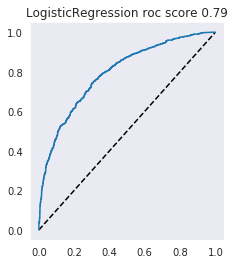

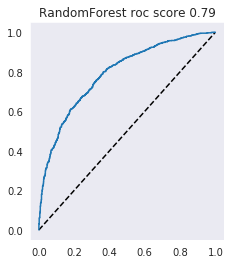

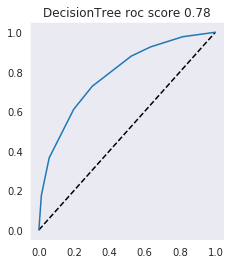

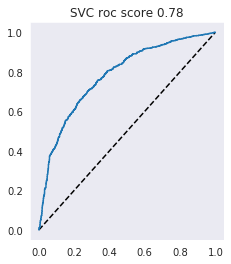

In [55]:
for i, (mName, m) in enumerate(clf.items()):
  # if mName == "SVC" : continue
  print(mName)
  fig = plt.figure(figsize=[16, 4])
  y_pred = m.predict_proba(X_test)[:, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred)
  ax = fig.add_subplot(1, 4, i+1)
  ax.plot([0, 1], [0, 1], 'k--')
  ax.plot(fpr, tpr)
  ax.set_title(mName + ' roc score {0:.2f}'.format(roc_auc_score(y_test, y_pred)))

plt.show()


## Simulate the world cup
I use the code from this [Kaggle notebook](https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner) so kudos for this guy
and also, since the REAL world cup outcome is quite surprise (Some strong team perform really bad eg. Germany)

ALso, quick TL;DR :

I run the test on each model and the predictions are got bias toward team rank (since our data only have rank). So I've decide to compare the result with FiveThirtyEight prediction before the tournament happen. If you look at the cells below you will see the result from decision tree model which I think it is the best model because I have test with all other model and the result are not resonable. From my own oppinion some model get a lot of bias toward the rank difference and some model just give a really random result.     

In [0]:
world_cup = schedule

# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rank.loc[(rank['rank_date'] == rank['rank_date'].max()) & 
                                    rank['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])



In [0]:
from itertools import combinations
model = clf['LogisticRegression']           ## change the model here!
opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        if home != 'Russia':
          row = pd.DataFrame(np.array([[np.nan, np.nan, False]]), columns=X_train.columns)
        else:
          row = pd.DataFrame(np.array([[np.nan, np.nan, True]]), columns=X_train.columns)
  
        home_rank = world_cup_rankings.loc[home, 'rank']
        # home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        # opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['avg_rank'] = (home_rank + opp_rank) / 2
        row['rank_diff'] = home_rank - opp_rank
        # row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        print(home, home_rank, away,opp_rank)


        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group G:___
Belgium vs. Panama: Belgium 3.0 Panama 55.0
Belgium wins with 0.74
Belgium vs. Tunisia: Belgium 3.0 Tunisia 21.0
Belgium wins with 0.58
Belgium vs. England: Belgium 3.0 England 12.0
Draw
Panama vs. Tunisia: Panama 55.0 Tunisia 21.0
Tunisia wins with 0.69
Panama vs. England: Panama 55.0 England 12.0
England wins with 0.73
Tunisia vs. England: Tunisia 21.0 England 12.0
England wins with 0.57
___Starting group C:___
France vs. Australia: France 7.0 Australia 36.0
France wins with 0.63
France vs. Peru: France 7.0 Peru 11.0
Draw
France vs. Denmark: France 7.0 Denmark 12.0
Draw
Australia vs. Peru: Australia 36.0 Peru 11.0
Peru wins with 0.65
Australia vs. Denmark: Australia 36.0 Denmark 12.0
Denmark wins with 0.64
Peru vs. Denmark: Peru 11.0 Denmark 12.0
Draw
___Starting group F:___
Germany vs. Mexico: Germany 1.0 Mexico 15.0
Germany wins with 0.55
Germany vs. Sweden: Germany 1.0 Sweden 24.0
Germany wins with 0.60
Germany vs. Korea Republic: Germany 1.0 Korea Republic

In [0]:
row

,avg_rank,rank_diff,is_home
0,29.5,31.0,0.0


In [0]:
# world_cup_rankings
# world_cup = world_cup.drop(['level_0','index'], axis=1)

In [0]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        if home != 'Russia':
          row = pd.DataFrame(np.array([[np.nan, np.nan, False]]), columns=X_train.columns)
        else:
          row = pd.DataFrame(np.array([[np.nan, np.nan, True]]), columns=X_train.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        # home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        # opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['avg_rank'] = (home_rank + opp_rank) / 2
        row['rank_diff'] = home_rank - opp_rank
        # row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.52
Brazil vs. Mexico: Brazil wins with probability 0.55
Belgium vs. Colombia: Belgium wins with probability 0.55
Egypt vs. Portugal: Portugal wins with probability 0.72
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.55
England vs. Poland: Poland wins with probability 0.54


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.52
Portugal vs. Argentina: Argentina wins with probability 0.52
Germany vs. Poland: Germany wins with probability 0.52


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Argentina vs. Germany: Germany wins with probability 0.54


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.53




## Baseline model
predict only win/ loss for each model

In [0]:
print(classification_report(y_test, np.zeros(y_test.shape)))

              precision    recall  f1-score   support

           0       0.52      1.00      0.69      1151
           1       0.00      0.00      0.00      1054

    accuracy                           0.52      2205
   macro avg       0.26      0.50      0.34      2205
weighted avg       0.27      0.52      0.36      2205



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
print(classification_report(y_test, np.ones(y_test.shape)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1151
           1       0.48      1.00      0.65      1054

    accuracy                           0.48      2205
   macro avg       0.24      0.50      0.32      2205
weighted avg       0.23      0.48      0.31      2205



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
